In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
n_agent = 4
horizon = 10
dt = 1.0
X = np.zeros(shape=(n_agent,horizon*6))  # [Xx, Xy, Vx, Vy, Ax, Ay] -> (horizon*6,)
MUE = np.zeros(shape=(n_agent,horizon*4)) # horizon*(2 speed, 2 acceleration) equation -> horizon*4 mue
init_x = np.array([[0., 0., -5., -5.],
                   [20., 0., 0., 0.],
                   [0., 20., 0., 0.],
                   [20., 20., 0., 0.]]) # (n_agent, Xx, Xy, Vx, Vy)
obstacle_pos = np.array([[-1.,10.],
                         [9.,3.]])
obstacle_r = np.array([3.,3.])
keep_dist = np.array([[0.,0.],[-1.,-1.],[1.,-1.], [0, -2]])
rho = 2
A = np.eye(n_agent)/2.+1/(n_agent*2)
V = init_x.copy()

In [16]:
def f_cost(X):
    avoid_obstacle = 0
    effort = 0
    diff = 0
    for i in range(n_agent):
        U = X[i][horizon*4:]
        X_ = X[i][:horizon*4]
        
        #  force agent to move to reference point
        rotated = rotation_matrix(keep_dist[i], X[0][3*horizon-1], X[0][4*horizon-1])
        
        diff = diff + np.abs(X_[horizon-1]-V[i][0]-rotated[0])**2 #  last points of x
        diff = diff + np.abs(X_[2*horizon-1]-V[i][1]-rotated[1])**2 # last points of y
        diff = diff + np.abs(X_[3*horizon-1]-V[i][2])**2 # final velocity-x = 0 
        diff = diff + np.abs(X_[4*horizon-1]-V[i][3])**2 # final velocity-y = 0 
        
        effort = effort + np.linalg.norm(U)**2
        
        avoid_obstacle += np.exp(-((X_[:horizon]-obstacle_pos[0][0])**2+(X_[horizon:horizon*2]-obstacle_pos[0][1])**2-obstacle_r[0]**2)).sum()
        avoid_obstacle += np.exp(-((X_[:horizon]-obstacle_pos[1][0])**2+(X_[horizon:horizon*2]-obstacle_pos[1][1])**2-obstacle_r[1]**2)).sum()
    
    return diff*10 + effort/10 + avoid_obstacle

In [17]:
def compute_gradient(X, f_for_grad):
    N_dim = X.shape[1]
    gradient_vector = np.zeros_like(X)
    h = 1e-3
    for i in range(n_agent):
        for k in range(N_dim):
            x_plus_h = X.copy()
            x_plus_h[i][k] += h

            x_minus_h = X.copy()
            x_minus_h[i][k] -= h

            gradient_vector[i][k] = (
                f_for_grad(x_plus_h[:,: horizon * 6], x_plus_h[:,horizon * 6 :])
                - f_for_grad(x_minus_h[:,: horizon * 6], x_minus_h[:,horizon * 6 :])
            ) / (2 * h)
    return gradient_vector

In [18]:
def Lagrangian(*X_and_MUE):
    X_, MUE_ = X_and_MUE
    f_term = f_cost(X_)
    lagrange_term = 0.0
    augmented_term = 0.0
    for n in range(n_agent):
        X = X_[n]
        MUE = MUE_[n]
        lagrange_term += MUE[0]*(X[0] - init_x[n][0] - X[horizon*2] * dt) # first mue for speed x eq
        lagrange_term += MUE[horizon]*(X[horizon] - init_x[n][1] - X[horizon*3] * dt) # first mue for speed y eq
        
        lagrange_term += MUE[horizon*2]*(X[horizon*2] - init_x[n][2] - X[horizon*4] * dt) # first mue for acc x eq
        lagrange_term += MUE[horizon*3]*(X[horizon*3] - init_x[n][3] - X[horizon*5] * dt) # first mue for acc y eq
        
        # augmented_term += (X[0] - init_x[n][0] - X[horizon*2] * dt)**2
        # augmented_term += (X[horizon] - init_x[n][1] - X[horizon*3] * dt)**2
        
        # augmented_term += (X[horizon*2] - init_x[n][2] - X[horizon*4] * dt)**2
        # augmented_term += (X[horizon*3] - init_x[n][3] - X[horizon*5] * dt)**2
        
        for i in range(1,horizon):
            lagrange_term += MUE[i]*(X[i] - X[i-1] - X[horizon*2+i] * dt)  # x_i = x_{i-1} + v_i*dt
            lagrange_term += MUE[i+horizon]*(X[i+horizon] - X[i+horizon-1] - X[horizon*3+i] * dt)  # y_i = y_{i-1} + vi*dt
            
            lagrange_term += MUE[i+horizon*2]*(X[i+horizon*2] - X[i+horizon*2-1] - X[horizon*4+i] * dt)  # vx_i = vx_{i-1} + ax_i*dt
            lagrange_term += MUE[i+horizon*3]*(X[i+horizon*3] - X[i+horizon*3-1] - X[horizon*5+i] * dt)  # vy_i = vy_{i-1} + ayi*dt
            
            # augmented_term += (X[i] - X[i-1] - X[horizon*2+i] * dt)**2
            # augmented_term += (X[i+horizon] - X[i+horizon-1] - X[horizon*3+i] * dt)**2
            
            # augmented_term += (X[i+horizon*2] - X[i+horizon*2-1] - X[horizon*4+i] * dt)**2
            # augmented_term += (X[i+horizon*3] - X[i+horizon*3-1] - X[horizon*5+i] * dt)**2
        
    return lagrange_term + f_term #+ rho*augmented_term/2

In [19]:
def fuse_data(A, X, k):
    
    if k == 0:
        return A@init_x
    else:
        selected_X = X[:,[horizon-1, horizon*2-1, horizon*3-1, horizon*4-1]] #last pos and speed
        for i in range(n_agent):
            selected_X[i,:2] = selected_X[i,:2] - rotation_matrix(keep_dist[i], selected_X[0,2], selected_X[0,3])
        # selected_X[:,:2] = selected_X[:,:2] - keep_dist
        V = A@selected_X 
        return V
    
def rotation_matrix(dists, x_vec, y_vec):
    vec = np.array([x_vec, y_vec])
    theta = np.arctan(vec[1]/(vec[0]+1e-9)) -np.pi/2
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c, -s), (s, c)))
    rotated = R@dists
    return rotated

In [20]:
X_values = [X]
X_current = X_values[-1]
V = init_x.copy()
f_values = [f_cost(X_current)]

MUE_values = [MUE]
MUE_current = MUE_values[-1]
lagrange_values = [Lagrangian(X_current, MUE_current)]

for k in range(500): 
    
    V = fuse_data(A, X, k)

    for _ in range(20):

        grad_input_for_Lagrangian = np.concatenate((X_current, MUE_current),axis = 1)
        gradient_vector = compute_gradient(grad_input_for_Lagrangian, Lagrangian)
        X_current = X_current - 0.01 * gradient_vector[:,: horizon * 6]  # update X


    grad_input_for_Lagrangian = np.concatenate((X_current, MUE_current),axis = 1)
    gradient_vector = compute_gradient(grad_input_for_Lagrangian, Lagrangian)
    MUE_current = MUE_current + 0.01 * gradient_vector[:,horizon * 6 :] # update MUE

    X_values.append(X_current.copy())
    f_values.append(f_cost(X_current))
    MUE_values.append(MUE_current.copy())
    lagrange_values.append(Lagrangian(X_current, MUE_current))

In [21]:
X_show = np.round(X_current[0], 1)
print('X: ', X_show[:horizon])
print('Vx: ', X_show[horizon*2:horizon*3])
print('Ax: ', X_show[horizon*4:horizon*5])
print('Y: ', X_show[horizon:horizon*2])
print('Vy: ', X_show[horizon*3:horizon*4])
print('Ay: ', X_show[-horizon:])

X:  [-2.6 -3.8 -4.  -3.3 -2.3 -1.5 -0.5 -0.1 -0.   0.5]
Vx:  [-2.2 -0.6  0.3  1.1  1.2  0.7  0.2  0.6  0.3  0.6]
Ax:  [ 1.9  1.7  1.3  0.6  0.4  0.1 -0.3 -0.6 -0.2  0. ]
Y:  [-2.7 -3.9 -3.9 -3.4 -2.9 -1.6 -0.8 -0.2  0.2  0. ]
Vy:  [-2.7 -1.1 -0.1  1.   2.   0.9  0.4  0.4 -0.1 -0.4]
Ay:  [ 1.9  1.5  1.2  0.6  0.   0.4  0.2 -0.2 -0.2 -0.4]


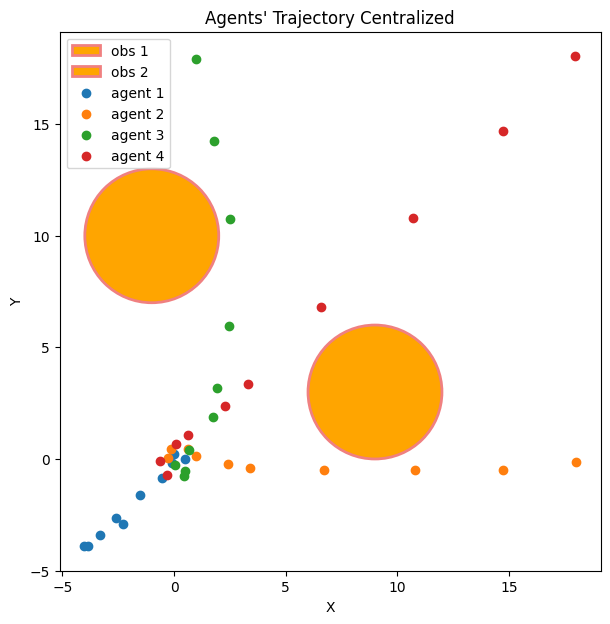

In [22]:
# Plotting the circle outline
circle1 = plt.Circle((obstacle_pos[0][0], obstacle_pos[0][1]), radius=obstacle_r[0], edgecolor='lightcoral', facecolor='orange', linewidth=2)
circle2 = plt.Circle((obstacle_pos[1][0], obstacle_pos[1][1]), radius=obstacle_r[1], edgecolor='lightcoral', facecolor='orange', linewidth=2)


# Creating the plot
fig, ax = plt.subplots(figsize = (7, 7))
ax.set_aspect('equal')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.scatter(X_current[0][:horizon], X_current[0][horizon:horizon*2]);
ax.scatter(X_current[1][:horizon], X_current[1][horizon:horizon*2]);
ax.scatter(X_current[2][:horizon], X_current[2][horizon:horizon*2]);
ax.scatter(X_current[3][:horizon], X_current[3][horizon:horizon*2]);
plt.title("Agents' Trajectory Centralized")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['obs 1', 'obs 2','agent 1', 'agent 2', 'agent 3', 'agent 4'])


# Displaying the plot
plt.show()

In [23]:
from PIL import Image

# Create a list of plots to be included in the GIF
plots = []
X_show = np.zeros((n_agent, horizon+1, 2))
X_show[:,0] = init_x[:,:2]
X_show[:, 1:, 0] = X_current[:,:horizon]
X_show[:, 1:, 1] = X_current[:,horizon:horizon*2]
    
    
# Generate and save each plot
for i in range(horizon+1):
    # Generate your plot here (replace this with your own plotting code)
    circle1 = plt.Circle((obstacle_pos[0][0], obstacle_pos[0][1]), radius=obstacle_r[0], edgecolor='lightcoral', facecolor='orange', linewidth=2)
    circle2 = plt.Circle((obstacle_pos[1][0], obstacle_pos[1][1]), radius=obstacle_r[1], edgecolor='lightcoral', facecolor='orange', linewidth=2)
    fig, ax = plt.subplots()
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    for j in range(n_agent):
        ax.scatter(X_show[j,i,0], X_show[j,i,1], label = f'agent {j+1}');
    ax.set_aspect('equal')
    plt.ylabel('Y')
    plt.ylabel('X')
    plt.xlim([-10.,25])
    plt.ylim([-10.,25])
    plt.title(f"Agents' Trajectory t={i+1} Centralized")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(['obs 1', 'obs 2','agent 1', 'agent 2', 'agent 3', 'agent 4'])
    plt.legend(loc = 1)
        
    # Save the plot as an image file
    filename = 'gifs/'+f'centralized_plot_{i+1}.png'
    plt.savefig(filename)
    
    # Close the plot to release memory
    plt.close()
    
    # Append the saved plot to the list
    plots.append(filename)

# Create a GIF from the saved plots
images = [Image.open(p) for p in plots]
images[0].save('gifs/centralized.gif', save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)

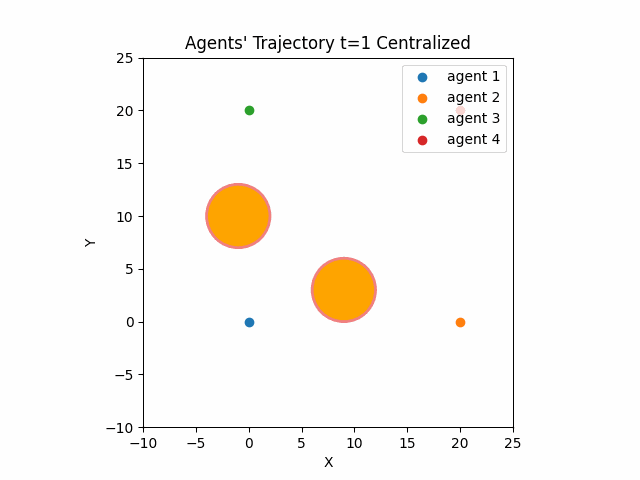

In [24]:
from IPython.display import Image, display

# Display the GIF
display(Image(filename='gifs/centralized.gif'))

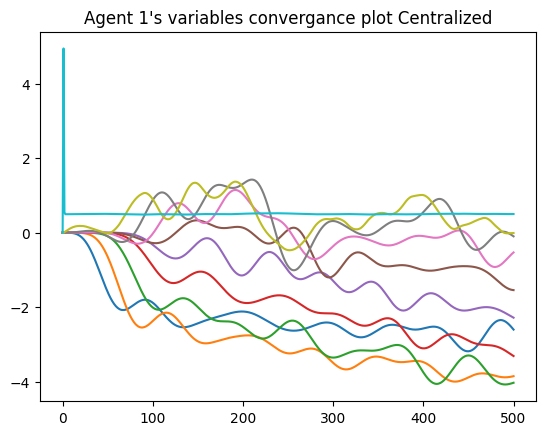

In [25]:
plt.plot(np.array(X_values)[:,0,:horizon]);
plt.title("Agent 1's variables convergance plot Centralized");


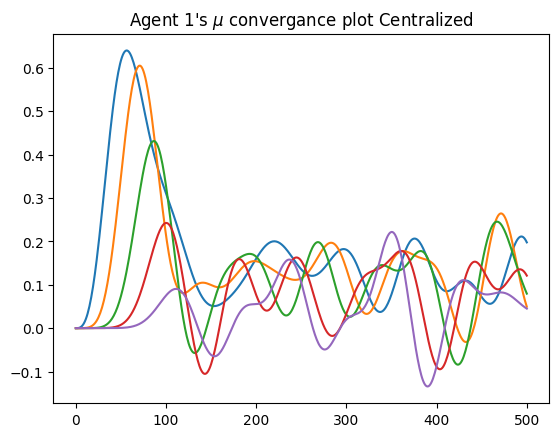

In [26]:
plt.plot(np.array(MUE_values)[:, 0, :5]);
plt.title("Agent 1's $\mu$ convergance plot Centralized");

Text(0.5, 1.0, 'f values over time')

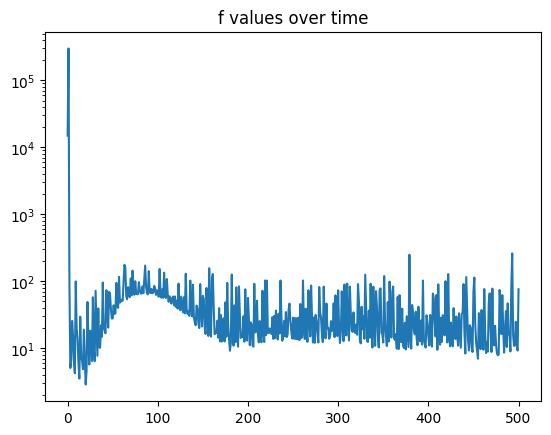

In [27]:
plt.semilogy(f_values)
plt.title('f values over time')